## This notebook has everything related to smoke estimates

In [1]:
%%capture
%pip install scipy
%pip install statsmodels
%pip install sklearn
%pip install pyarrow

In [21]:
import polars as pl
import pyarrow
import matplotlib.pyplot as plt

In [3]:
wildfires_with_distances = pl.read_csv("generated_files/intermediate/wildfires_with_distances.csv")

# find wildfires within 650 miles from the city of interest
wildfires_in_proximity = (
    wildfires_with_distances
    .filter(
        pl.col("Closest_Distance_Miles") <= 650
    )
) 

wildfires_in_proximity

OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,Listed_Fire_Codes,Listed_Fire_IDs,Listed_Fire_IRWIN_IDs,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Listed_Map_Digitize_Methods,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,Closest_Distance_Miles
i64,i64,str,i64,i64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64
14600,14600,"""Wildfire""",1964,1,"""1 (1), 3 (3)""",65338.877636,26441.705659,"""Comb_National_NIFC_Interagency…","""Wildfire (3), Likely Wildfire …","""COYOTE (4)""","""No code provided (4)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (1…","""Undetermined (4)""",null,null,null,null,0.263753,null,"""No""",112240.801495,2.6442e8,250.77864
14601,14601,"""Wildfire""",1964,1,"""1 (2), 3 (3), 5 (1)""",55960.694158,22646.489455,"""Comb_National_NIFC_Interagency…","""Wildfire (5), Likely Wildfire …","""C. HANLY (5), Hanley (1)""","""No code provided (5), 198 (1)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (1…","""Undetermined (6)""",null,null,null,null,0.224592,null,"""No""",112566.141954,2.2646e8,76.420104
14602,14602,"""Wildfire""",1964,1,"""1 (2), 3 (3)""",19218.105903,7777.29153,"""Comb_National_NIFC_Interagency…","""Wildfire (4), Likely Wildfire …","""COZY DELL (5)""","""No code provided (5)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (1…","""Undetermined (5)""",null,null,null,null,0.138493,null,"""No""",84004.974692,7.7773e7,327.916719
14603,14603,"""Wildfire""",1964,1,"""1 (2), 3 (3)""",18712.494746,7572.677954,"""Comb_National_NIFC_Interagency…","""Wildfire (4), Likely Wildfire …","""HAYFORK HWY. #2 (5)""","""No code provided (5)""","""0 (3)""",null,"""Listed Wildfire Discovery Date…","""9 - Miscellaneous (1)""","""Undetermined (4), Human (1)""",null,null,null,null,0.39196,null,"""No""",49273.004457,7.5727e7,198.853859
14604,14604,"""Wildfire""",1964,1,"""1 (4), 3 (6)""",16887.001024,6833.926855,"""Comb_National_NIFC_Interagency…","""Wildfire (8), Likely Wildfire …","""MATTOLE (5), ROBERTS COOP. ESC…","""No code provided (10)""","""0 (6)""",null,"""Listed Wildfire Discovery Date…","""14 - Unknown / Unidentified (2…","""Undetermined (10)""",null,null,null,null,0.392989,null,"""No""",46746.577459,6.8339e7,219.778526
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
135056,135056,"""Prescribed Fire""",2020,8,"""8 (2)""",14.545208,5.886237,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (2)""","""2_PHMA_FIAT_Beulah_East_Bendir…","""No code provided (2)""","""NFPORS6318576 (2)""",null,"""Listed Prescribed Fire End Dat…","""Human (2)""","""Human (2)""",null,null,null,null,0.29925,null,"""No""",1572.196739,58862.370422,453.342716
135057,135057,"""Prescribed Fire""",2020,8,"""8 (3)""",16.412148,6.641761,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (3)""","""WEW CA Broadcast (3)""","""No code provided (3)""","""NFPORS6319933 (3)""",null,"""Listed Prescribed Fire End Dat…","""Human (3)""","""Human (3)""",null,null,null,"""Caution, this Prescribed Fire …",0.177425,null,"""No""",2168.90074,66417.60679,406.63243
135058,135058,"""Prescribed Fire""",2020,8,"""8 (1)""",7.050837,2.853373,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (1)""","""2_PHMA_FIAT_Beulah_East_Bendir…","""No code provided (1)""","""NFPORS6318576 (1)""",null,"""Listed Prescribed Fire End Dat…","""Human (1)""","""Human (1)""",null,null,null,"""Caution, this Prescribed Fire …",0.374368,null,"""No""",978.666221,28533.725602,449.230338


In [4]:
# doing some EDA
print("Available columns")
wildfires_in_proximity.columns


Available columns


['OBJECTID',
 'USGS_Assigned_ID',
 'Assigned_Fire_Type',
 'Fire_Year',
 'Fire_Polygon_Tier',
 'Fire_Attribute_Tiers',
 'GIS_Acres',
 'GIS_Hectares',
 'Source_Datasets',
 'Listed_Fire_Types',
 'Listed_Fire_Names',
 'Listed_Fire_Codes',
 'Listed_Fire_IDs',
 'Listed_Fire_IRWIN_IDs',
 'Listed_Fire_Dates',
 'Listed_Fire_Causes',
 'Listed_Fire_Cause_Class',
 'Listed_Rx_Reported_Acres',
 'Listed_Map_Digitize_Methods',
 'Wildfire_and_Rx_Flag',
 'Overlap_Within_1_or_2_Flag',
 'Circleness_Scale',
 'Circle_Flag',
 'Exclude_From_Summary_Rasters',
 'Shape_Length',
 'Shape_Area',
 'Closest_Distance_Miles']

In [5]:
wildfires_in_proximity.group_by("Assigned_Fire_Type").len()

Assigned_Fire_Type,len
str,u32
"""Unknown - Likely Prescribed Fi…",124
"""Unknown - Likely Wildfire""",43
"""Likely Wildfire""",1562
"""Prescribed Fire""",13920
"""Wildfire""",36813


In [6]:
wildfires_in_proximity.group_by("Circle_Flag").len() # too many nulls, can ignore

Circle_Flag,len
f64,u32
1.0,4826
null,47636


In [7]:
wildfires_in_proximity.filter(pl.col("OBJECTID") != pl.col("USGS_Assigned_ID")) # identical columns

OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,Listed_Fire_Codes,Listed_Fire_IDs,Listed_Fire_IRWIN_IDs,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Listed_Map_Digitize_Methods,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,Closest_Distance_Miles
i64,i64,str,i64,i64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64


In [8]:
print("Min GIS acres burnt")
print(wildfires_in_proximity.select("GIS_Acres").min())

print("Max GIS acres burnt")
print(wildfires_in_proximity.select("GIS_Acres").max())

Min GIS acres burnt
shape: (1, 1)
┌───────────┐
│ GIS_Acres │
│ ---       │
│ f64       │
╞═══════════╡
│ 0.000005  │
└───────────┘
Max GIS acres burnt
shape: (1, 1)
┌───────────┐
│ GIS_Acres │
│ ---       │
│ f64       │
╞═══════════╡
│ 1.0327e6  │
└───────────┘


In [9]:
# selecting fields that might be useful to estimate smoke
wildfires_compact_df = (
    wildfires_in_proximity
    .select([
        # 'OBJECTID', # since the value is same as USGS_Assigned_ID
        'USGS_Assigned_ID',
        'Assigned_Fire_Type',
        'Fire_Year',
        # 'Fire_Polygon_Tier',
        # 'Fire_Attribute_Tiers',
        'GIS_Acres',
        # 'GIS_Hectares', # since we are already considering area under the field GIS_Acres
        # 'Source_Datasets',
        # 'Listed_Fire_Types',
        # 'Listed_Fire_Names',
        # 'Listed_Fire_Codes',
        # 'Listed_Fire_IDs',
        # 'Listed_Fire_IRWIN_IDs',
        # 'Listed_Fire_Dates',
        # 'Listed_Fire_Causes',
        # 'Listed_Fire_Cause_Class',
        # 'Listed_Rx_Reported_Acres',
        # 'Listed_Map_Digitize_Methods',
        # 'Wildfire_and_Rx_Flag',
        # 'Overlap_Within_1_or_2_Flag',
        'Circleness_Scale',
        # 'Circle_Flag', # since majority are nulls, and we already considered Circleness_Scale
        # 'Exclude_From_Summary_Rasters',
        'Shape_Length',
        'Shape_Area',
        'Closest_Distance_Miles'
    ])
)

wildfires_compact_df

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles
i64,str,i64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526
…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338


In [10]:
# creating a dataframe to map the assigned firetypes to a value

firetypes_df = pl.DataFrame(
    [
        {
            "fire_type": "Unknown - Likely Wildfire",
            "factor": 0.7
        },
        {
            "fire_type": "Likely Wildfire",
            "factor": 0.8
        },
        {
            "fire_type": "Unknown - Likely Prescribed Fire",
            "factor": 0.7
        },
        {
            "fire_type": "Prescribed Fire",
            "factor": 1.0
        },
        {
            "fire_type": "Wildfire",
            "factor": 1.0
        }
    ]
)

firetypes_df

fire_type,factor
str,f64
"""Unknown - Likely Wildfire""",0.7
"""Likely Wildfire""",0.8
"""Unknown - Likely Prescribed Fi…",0.7
"""Prescribed Fire""",1.0
"""Wildfire""",1.0


In [11]:
wildfires_enriched_1 = (
    wildfires_compact_df
    .join(
        firetypes_df,
        left_on = "Assigned_Fire_Type",
        right_on = "fire_type"
    )
    .rename(
        {
            "factor": "fire_type_factor"
        }
    )
)
wildfires_enriched_1

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,fire_type_factor
i64,str,i64,f64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864,1.0
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104,1.0
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719,1.0
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859,1.0
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526,1.0
…,…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716,1.0
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243,1.0
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338,1.0


In [12]:
# calculating a shape factor by using the shape length, shape area and circleness

wildfires_enriched_2 = (
    wildfires_enriched_1
    .with_columns(
        (1/pl.col("Closest_Distance_Miles")).alias("distance_factor"), # assuming the smoke is invesrly proportional
        (pl.col("GIS_Acres").sqrt().round(2)).alias("area_factor"), # to make sure that area doesnt over inflate the smoke
    )
)

wildfires_enriched_2

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,fire_type_factor,distance_factor,area_factor
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864,1.0,0.003988,255.61
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104,1.0,0.013086,236.56
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719,1.0,0.00305,138.63
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859,1.0,0.005029,136.79
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526,1.0,0.00455,129.95
…,…,…,…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716,1.0,0.002206,3.81
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243,1.0,0.002459,4.05
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338,1.0,0.002226,2.66


In [13]:
wildfires_enriched = (
    wildfires_enriched_2
    .with_columns(
        (pl.col("fire_type_factor") * pl.col("distance_factor") * pl.col("area_factor") * pl.col("Circleness_Scale")).alias("smoke_estimate")
    )
)
wildfires_enriched

USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,fire_type_factor,distance_factor,area_factor,smoke_estimate
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
14600,"""Wildfire""",1964,65338.877636,0.263753,112240.801495,2.6442e8,250.77864,1.0,0.003988,255.61,0.268835
14601,"""Wildfire""",1964,55960.694158,0.224592,112566.141954,2.2646e8,76.420104,1.0,0.013086,236.56,0.695231
14602,"""Wildfire""",1964,19218.105903,0.138493,84004.974692,7.7773e7,327.916719,1.0,0.00305,138.63,0.058549
14603,"""Wildfire""",1964,18712.494746,0.39196,49273.004457,7.5727e7,198.853859,1.0,0.005029,136.79,0.269626
14604,"""Wildfire""",1964,16887.001024,0.392989,46746.577459,6.8339e7,219.778526,1.0,0.00455,129.95,0.232365
…,…,…,…,…,…,…,…,…,…,…,…
135056,"""Prescribed Fire""",2020,14.545208,0.29925,1572.196739,58862.370422,453.342716,1.0,0.002206,3.81,0.002515
135057,"""Prescribed Fire""",2020,16.412148,0.177425,2168.90074,66417.60679,406.63243,1.0,0.002459,4.05,0.001767
135058,"""Prescribed Fire""",2020,7.050837,0.374368,978.666221,28533.725602,449.230338,1.0,0.002226,2.66,0.002217


In [14]:
smoke_estimates_yearly = (

    wildfires_enriched
    .group_by("Fire_Year")
    .agg(
        pl.sum("smoke_estimate"),
    )
    .sort("Fire_Year")
)

smoke_estimates_yearly

Fire_Year,smoke_estimate
i64,f64
1964,17.757395
1965,7.891844
1966,18.259437
1967,10.625853
1968,16.536229
…,…
2016,29.003212
2017,48.263021
2018,38.374925


In [15]:
smoke_estimates_yearly.write_csv("generated_files/intermediate/smoke_estimates_1964-2024.csv")

# checking relation between smoke estimates and aqi

In [16]:
yearly_aqi_weighted_avg = pl.read_csv("generated_files/intermediate/yearly_weighted_aqi_1964-2024.csv")
yearly_aqi_weighted_avg

year,weighted_avg_aqi
i64,f64
1964,32.41
1965,25.73
1966,21.06
1967,26.93
1968,25.57
…,…
2020,59.25
2021,52.98
2022,43.03


In [18]:
from scipy.stats import pearsonr

# smoke data only till 2020, while aqi data is till 2024
yearly_aqi_1964_2020 = (
    yearly_aqi_weighted_avg
    .filter(
        pl.col("year").is_between(1964, 2020)
    )
)
# Calculate Pearson correlation and p-value
correlation, p_value = pearsonr(yearly_aqi_1964_2020["weighted_avg_aqi"],smoke_estimates_yearly["smoke_estimate"])

# Display the correlation
print(f"Pearson correlation coefficient: {correlation}")

Pearson correlation coefficient: 0.36464901425861485


### Building predictive model

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:

# Split data into train and test sets
training_data = (
    smoke_estimates_yearly
    .filter(pl.col("Fire_Year") < 2015)
)["smoke_estimate"].to_pandas()

test_data = (
    smoke_estimates_yearly
    .filter(pl.col("Fire_Year") > 2015)
)["smoke_estimate"].to_pandas()

# ARIMA Model
arima_model = ARIMA(training_data, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=len(training_data), end=len(training_data)+len(test_data)-1, typ='levels')
arima_mse = mean_squared_error(test_data, arima_pred)
print(arima_mse)

124.19729453330952


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:         smoke_estimate   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -177.065
Date:                Tue, 29 Oct 2024   AIC                            360.131
Time:                        23:29:33   BIC                            365.867
Sample:                             0   HQIC                           362.315
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0309      0.230      0.134      0.893      -0.420       0.482
ma.L1         -0.7179      0.185     -3.877      0.000      -1.081      -0.355
sigma2        68.7943     12.711      5.412      0.0

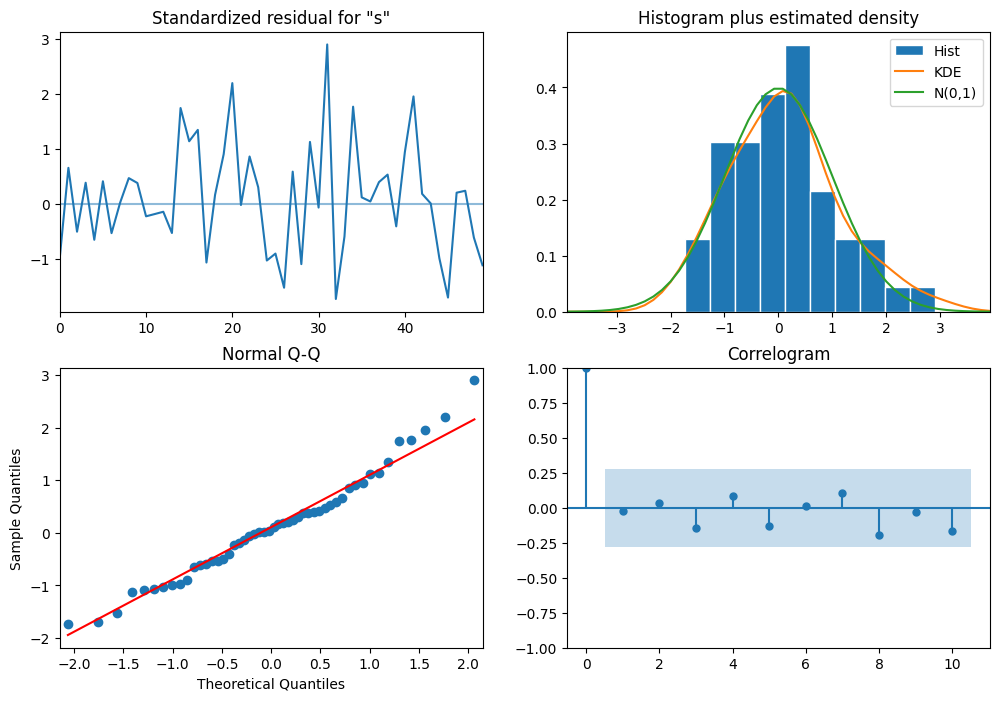

In [24]:
# Summarize the model results
print(arima_result.summary())

# Plot diagnostics
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

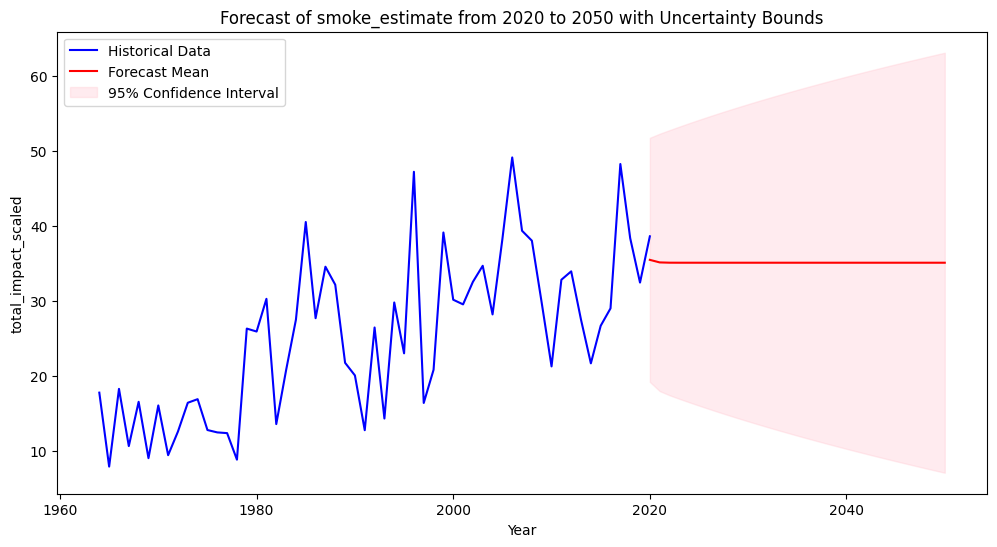

In [25]:
smoke_estimate_data = smoke_estimates_yearly["smoke_estimate"].to_pandas()

# Forecasting for 2020-2050 with ARIMA and calculating uncertainty bounds
forecast_years = range(2020, 2051)
n_forecasts = len(forecast_years)
forecast_result = ARIMA(smoke_estimate_data, order=(1, 1, 1)).fit()
forecast = forecast_result.get_forecast(steps=n_forecasts)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Plotting historical data and forecast with uncertainty bounds
plt.figure(figsize=(12, 6))
plt.plot(smoke_estimates_yearly['Fire_Year'], smoke_estimates_yearly['smoke_estimate'], label='Historical Data', color='blue')
plt.plot(forecast_years, forecast_mean, label='Forecast Mean', color='red')
plt.fill_between(forecast_years, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("Forecast of smoke_estimate from 2020 to 2050 with Uncertainty Bounds")
plt.xlabel("Year")
plt.ylabel("total_impact_scaled")
plt.legend()
plt.show()